# Part 1: Getting started

In [19]:

# from tensorflow.
from keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

%matplotlib inline
seed = 0
import os
# os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os

%load_ext autoreload
%autoreload 2
# os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import hls4ml
# import tf_keras as keras
# print(tensorflow.__file__)
print(tf.__version__)
# print(tf.keras.__version__)
# from keras.utils import to_categorical

# print("TensorFlow version:", tf.__version__)
# print("Is GPU available:", tf.config.list_physical_devices('GPU'))

2.14.0


In [6]:
# import subprocess
print(subprocess.getoutput("echo | $CC -E -v -xc++ -"))
# print("CC env:", subprocess.getoutput("echo $CC"))
# print("Which CC:", subprocess.getoutput("which $CC"))
# print("CC version:\n", subprocess.getoutput("$CC --version"))

Using built-in specs.
COLLECT_GCC=gcc-14
Target: x86_64-apple-darwin24
Configured with: ../configure --prefix=/usr/local/opt/gcc --libdir=/usr/local/opt/gcc/lib/gcc/current --disable-nls --enable-checking=release --with-gcc-major-version-only --enable-languages=c,c++,objc,obj-c++,fortran,m2 --program-suffix=-14 --with-gmp=/usr/local/opt/gmp --with-mpfr=/usr/local/opt/mpfr --with-mpc=/usr/local/opt/libmpc --with-isl=/usr/local/opt/isl --with-zstd=/usr/local/opt/zstd --with-pkgversion='Homebrew GCC 14.2.0_1' --with-bugurl=https://github.com/Homebrew/homebrew-core/issues --with-system-zlib --build=x86_64-apple-darwin24 --with-sysroot=/Library/Developer/CommandLineTools/SDKs/MacOSX15.sdk
Thread model: posix
Supported LTO compression algorithms: zlib zstd
gcc version 14.2.0 (Homebrew GCC 14.2.0_1) 
COLLECT_GCC_OPTIONS='-E' '-v' '-mmacosx-version-min=15.0.0' '-asm_macosx_version_min=15.0' '-nodefaultexport' '-mtune=core2'
 /usr/local/Cellar/gcc/14.2.0_1/bin/../libexec/gcc/x86_64-apple-darwin

In [ ]:
import os
import numpy as np

seed = 0
np.random.seed(seed)

# TensorFlow and Keras imports
import tensorflow as tf
tf.random.set_seed(seed)

# from tensorflow.keras.utils import to_categorical
from keras.utils import to_categorical
# Scikit-learn imports
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Jupyter magic (only needed in notebooks)
%matplotlib inline
%load_ext autoreload
%autoreload 2
# from tensorflow.keras.utils import to_categorical

## Fetch the jet tagging dataset from Open ML

In [21]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

/Users/yubo/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


### Let's print some information about the dataset
Print the feature names and the dataset shape

In [ ]:
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])

In [ ]:
print(y[:5])

As you saw above, the `y` target is an array of strings, e.g. \['g', 'w',...\] etc.
We need to make this a "One Hot" encoding for the training.
Then, split the dataset into training and validation sets

In [22]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [ ]:
X_train_val[0:5]

In [ ]:
X_test[0:5]

In [23]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)


# Standardize features by removing the mean and scaling to unit variance.
# The standard score of a sample x is calculated as:
# z = (x - u) / s
# where u is the mean of the training samples or zero if with_mean=False, 
# and s is the standard deviation of the training samples or one if with_std=False.

In [ ]:
X_test[0:5]

In [24]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

## Now construct a model
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks


In [26]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_1'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [27]:
train = True
if train:
    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_1',
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        # batch_size=32,
        epochs=20,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
else:
    from tensorflow.keras.models import load_model

    model = load_model('model_1/KERAS_check_best_model.h5')

Epoch 1/20
483/487 [============================>.] - ETA: 0s - loss: 1.3436 - accuracy: 0.4881
***callbacks***
saving losses to model_1/losses.log

Epoch 1: val_loss improved from inf to 1.14711, saving model to model_1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 1.14711, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_1/KERAS_check_model_last.h5

Epoch 1: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 3s 5ms/step - loss: 1.3421 - accuracy: 0.4892 - val_loss: 1.1471 - val_accuracy: 0.6294 - lr: 1.0000e-04
Epoch 2/20
 14/487 [..............................] - ETA: 1s - loss: 1.1401 - accuracy: 0.6300

/Users/yubo/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


471/487 [============================>.] - ETA: 0s - loss: 1.0798 - accuracy: 0.6580
***callbacks***
saving losses to model_1/losses.log

Epoch 2: val_loss improved from 1.14711 to 1.01975, saving model to model_1/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 1.14711 to 1.01975, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 2: saving model to model_1/KERAS_check_model_last.h5

Epoch 2: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 4ms/step - loss: 1.0777 - accuracy: 0.6589 - val_loss: 1.0198 - val_accuracy: 0.6831 - lr: 1.0000e-04
Epoch 3/20
485/487 [============================>.] - ETA: 0s - loss: 0.9697 - accuracy: 0.6985
***callbacks***
saving losses to model_1/losses.log

Epoch 3: val_loss improved from 1.01975 to 0.93053, saving model to model_1/KERAS_check_best_model.h5

Epoch 3: val_loss improved from 1.01975 to 0.93053, saving model to model_1/KERAS_check_best_model_

## Check performance
Check the accuracy and make a ROC curve

5188/5188 [==============================] - 6s 1ms/step
Accuracy: 0.7463493975903615


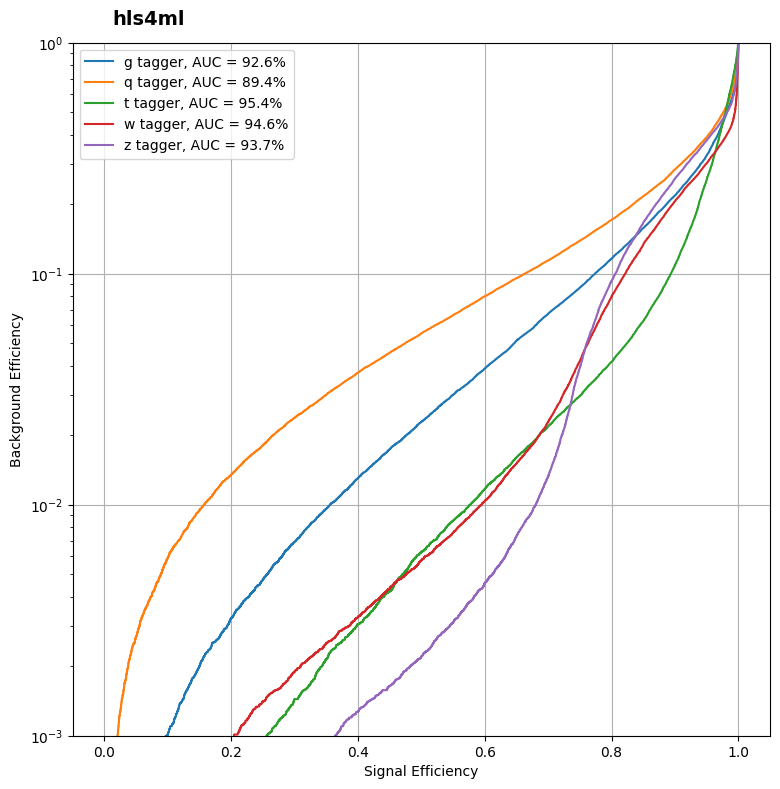

In [29]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)

## Convert the model to FPGA firmware with hls4ml
Now we will go through the steps to convert the model we trained to a low-latency optimized FPGA firmware with hls4ml.
First, we will evaluate its classification performance to make sure we haven't lost accuracy using the fixed-point data types. 
Then we will synthesize the model with Vitis HLS and check the metrics of latency and FPGA resource usage.

### Make an hls4ml config & model
The hls4ml Neural Network inference library is controlled through a configuration dictionary.
In this example we'll use the most simple variation, later exercises will look at more advanced configuration.

In [30]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='Vitis')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vitis', output_dir='model_1/hls4ml_prj', part='xc7a200tsbg484-1'
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Configuration
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       1
  S

Let's visualise what we created. The model architecture is shown, annotated with the shape and data types

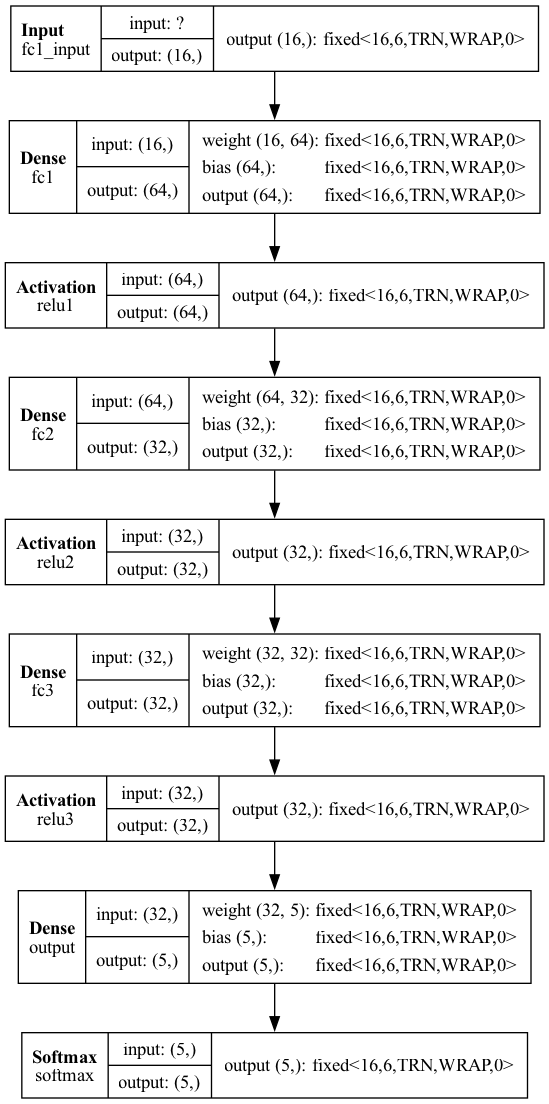

In [31]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Compile, predict
Now we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation on the CPU.

In [18]:
hls_model.write() 
# modify build_lib.sh to use gcc

Writing HLS project
Done


In [32]:
import os
import subprocess

# os.environ["CC"] = "gcc-14"
# os.environ["CXX"] = "g++-14"

# Check CC and CXX environment variables
print("CC =", os.environ.get("CC"))
print("CXX =", os.environ.get("CXX"))

# print(subprocess.getoutput("echo | $CC -v -E -xc++ -"))


CC = gcc-14
CXX = g++-14


In [37]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)
# print(hls4ml.__file__)

skip writing !!!!!!!


## Compare
That was easy! Now let's see how the performance compares to Keras:

Keras  Accuracy: 0.7463493975903615
hls4ml Accuracy: 0.746421686746988


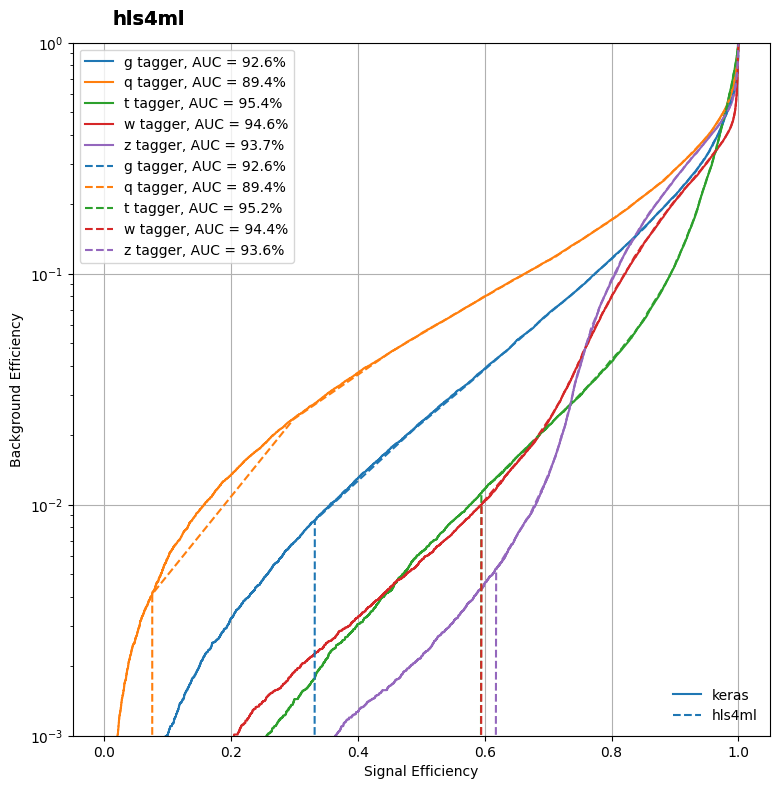

In [38]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, le.classes_, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Synthesize
Now we'll actually use Vitis HLS to synthesize the model. We can run the build using a method of our `hls_model` object.
After running this step, we can integrate the generated IP into a workflow to compile for a specific FPGA board.
In this case, we'll just review the reports that Vitis HLS generates, checking the latency and resource usage.

**This can take several minutes.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj/vitis_hls.log`

In [ ]:
hls_model.build(csim=False)

## Check the reports
Print out the reports generated by Vitis HLS. Pay attention to the Latency and the 'Utilization Estimates' sections

In [ ]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')

## Exercise
Since `ReuseFactor = 1` we expect each multiplication used in the inference of our neural network to use 1 DSP. Is this what we see? (Note that the Softmax layer should use 5 DSPs, or 1 per class)
Calculate how many multiplications are performed for the inference of this network...
(We'll discuss the outcome)